In [71]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
AEP = pd.read_csv("../Data Analytics/Git_Clone_PakHandaru/datasets/AEP_hourly.csv", encoding='utf-8-sig')

AEP.head(5)

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [74]:
AEP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [75]:
AEP['Datetime'] = pd.to_datetime(AEP['Datetime'])
AEP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  121273 non-null  datetime64[ns]
 1   AEP_MW    121273 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.9 MB


In [76]:
AEP.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [77]:
print(AEP.columns)

Index(['Datetime', 'AEP_MW'], dtype='object')


In [78]:
# Ubah kolom 'Datetime' jadi datetime dan set sebagai index
AEP['Datetime'] = pd.to_datetime(AEP['Datetime'])
AEP = AEP.set_index('Datetime')
AEP = AEP.sort_index()

# Baru bisa di-resample per hari
AEPdaily = AEP.resample('D').sum()

# Cek hasil
print(AEPdaily.tail())


              AEP_MW
Datetime            
2018-07-30  368834.0
2018-07-31  364327.0
2018-08-01  363628.0
2018-08-02  376504.0
2018-08-03   14809.0


In [79]:
AEPdaily = AEPdaily.iloc[:-1]
print(AEPdaily.tail())

              AEP_MW
Datetime            
2018-07-29  327792.0
2018-07-30  368834.0
2018-07-31  364327.0
2018-08-01  363628.0
2018-08-02  376504.0


<Axes: title={'center': 'Konsumsi Energi Harian (MW)'}, xlabel='Datetime'>

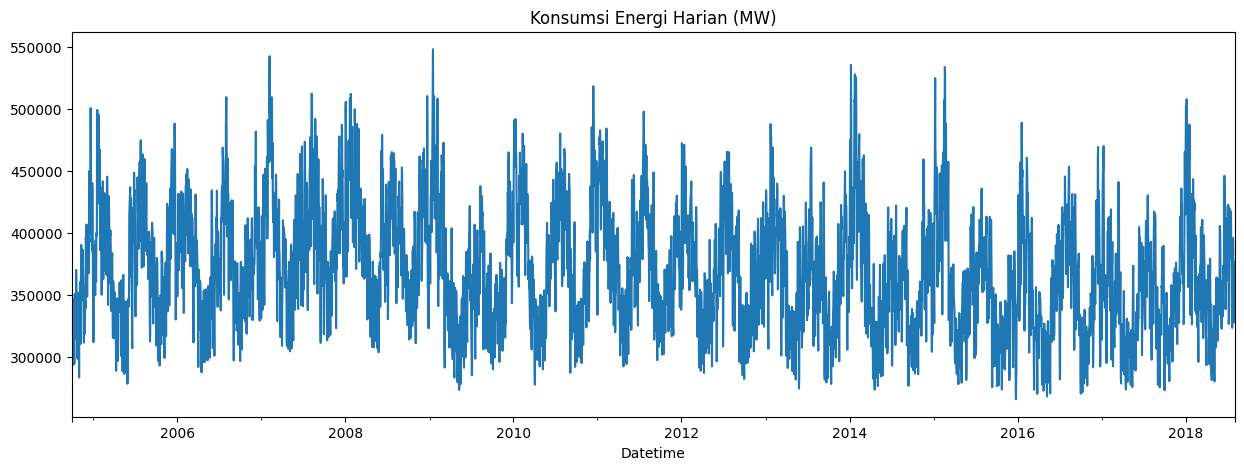

In [80]:
# Plot Konsumsi Energi Harian dan Trend
AEPdaily['AEP_MW'].plot(figsize=(15,5), title='Konsumsi Energi Harian (MW)')

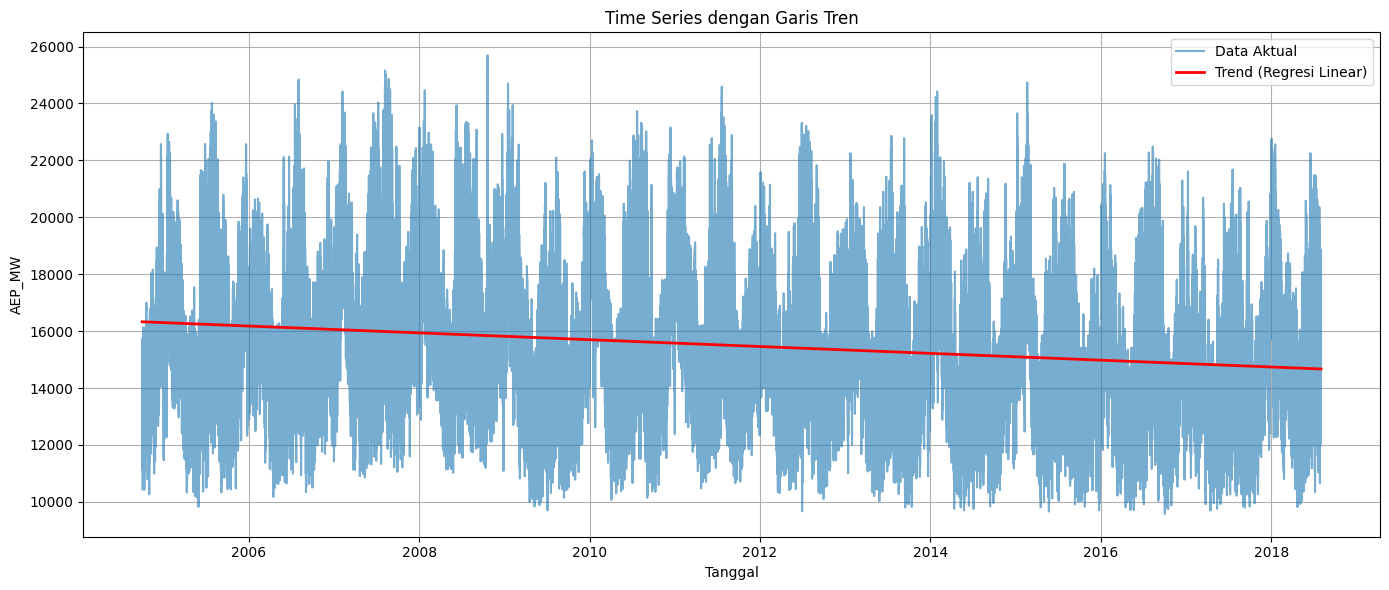

In [81]:
from sklearn.linear_model import LinearRegression

# Misalnya: daily_listrik (sudah datetime index), dan kolom nilai: 'AEP_MW'
data = AEP.copy().dropna()
y = data['AEP_MW'].values
X = np.arange(len(y)).reshape(-1, 1)  # waktu sebagai variabel independen

model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)

plt.figure(figsize=(14, 6))
plt.plot(data.index, y, label='Data Aktual', alpha=0.6)
plt.plot(data.index, trend, label='Trend (Regresi Linear)', color='red', linewidth=2)
plt.title("Time Series dengan Garis Tren")
plt.xlabel("Tanggal")
plt.ylabel("AEP_MW")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Rata-rata Konsumsi per Jam'}, xlabel='hour'>

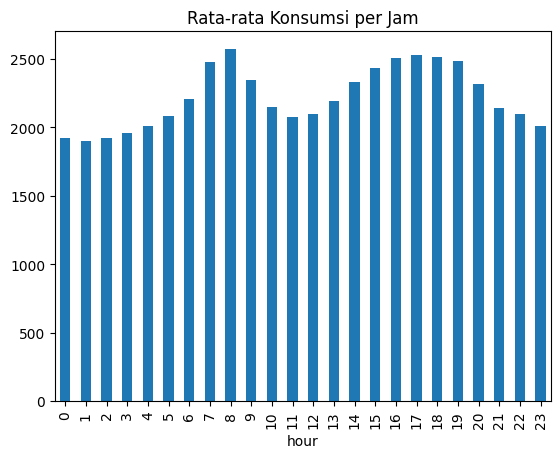

In [ ]:
AEP.groupby('hour')['AEP_MW'].mean().plot(kind='bar', title='Rata-rata Konsumsi per Jam')

<Axes: title={'center': 'Rata-rata Konsumsi per Hari'}, xlabel='weekday'>

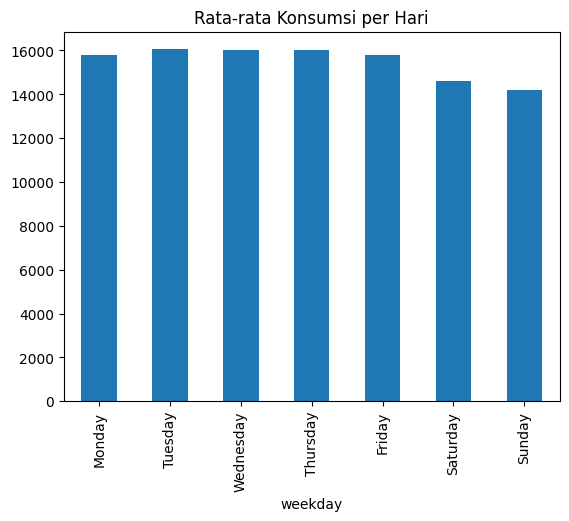

In [89]:
# Analisis Berdasarkan Hari dalam Seminggu
AEP['weekday'] = AEP.index.day_name()
AEP.groupby('weekday')['AEP_MW'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
).plot(kind='bar', title='Rata-rata Konsumsi per Hari')


C:\Users\71477\AppData\Local\Temp\ipykernel_33720\3806464679.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = AEP[['AEP_MW']].resample('M').mean()


<Axes: title={'center': 'Rata-rata Bulanan Konsumsi Energi (MW)'}, xlabel='Datetime'>

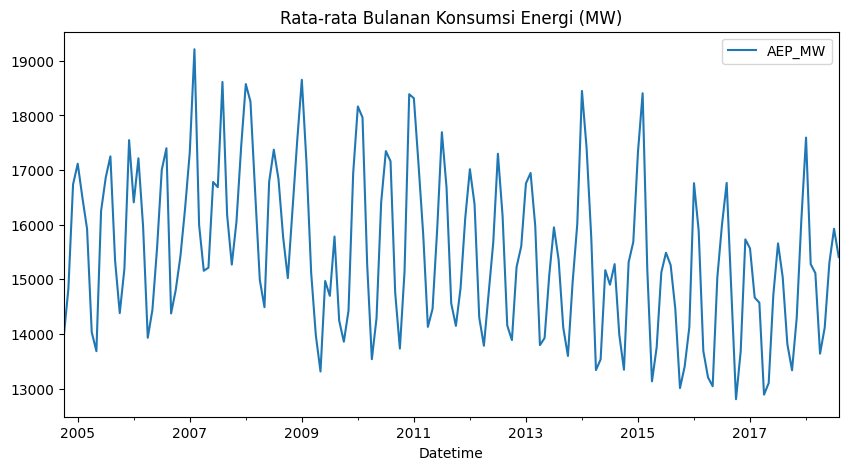

In [92]:
# Analisis Bulanan dan Musiman
monthly_avg = AEP[['AEP_MW']].resample('M').mean()
monthly_avg.plot(title='Rata-rata Bulanan Konsumsi Energi (MW)', figsize=(10, 5))

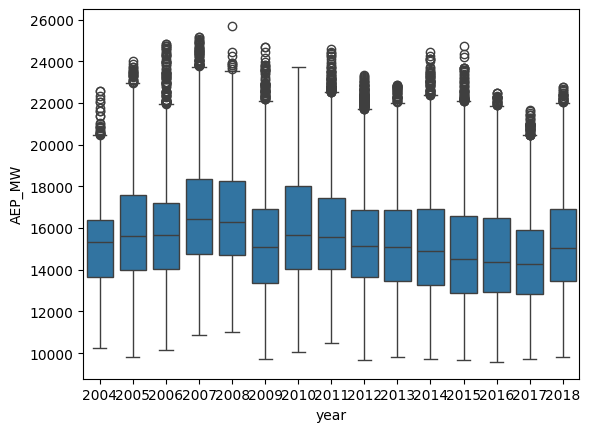

<Figure size 2000x500 with 0 Axes>

In [99]:
# Boxplot Tahunan dan Musiman
import seaborn as sns
AEP['year'] = AEP.index.year
sns.boxplot(x='year', y='AEP_MW', width = 0.8,data=AEP.reset_index())

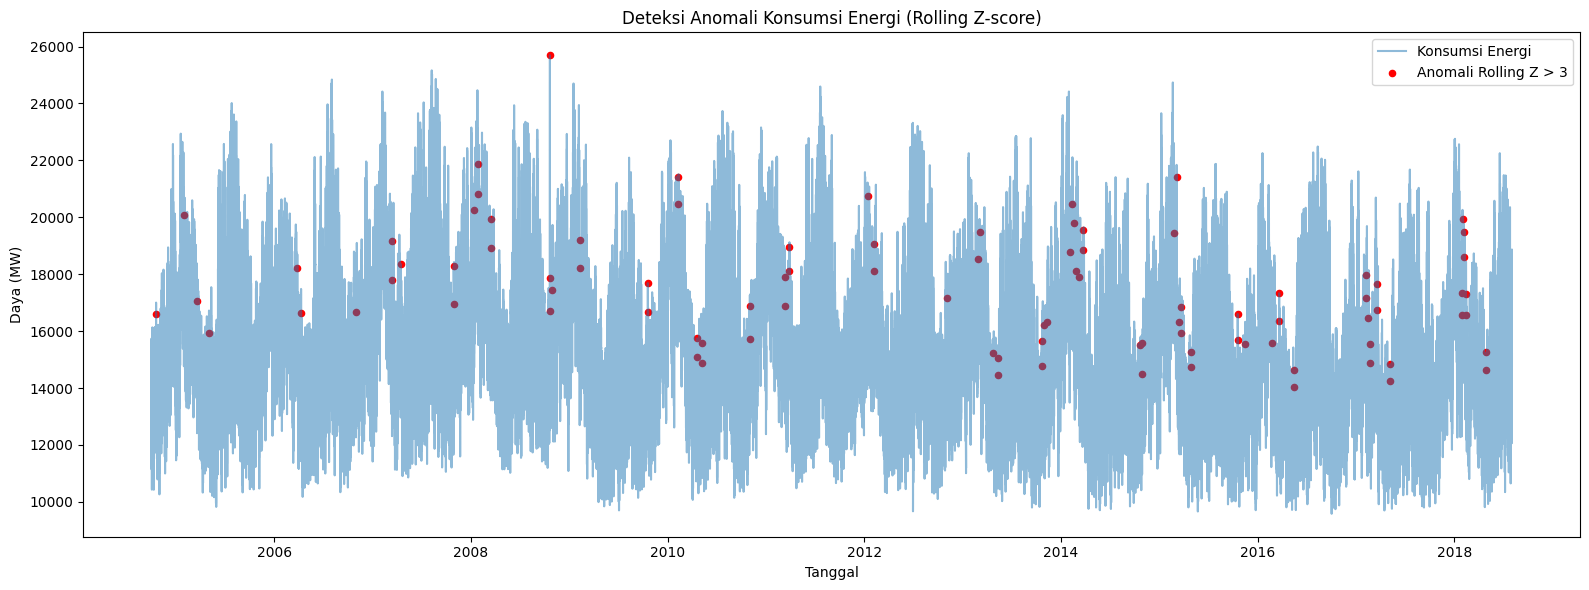

In [124]:
# Rolling window selama 24 jam
window = 24
AEP['rolling_mean'] = AEP['AEP_MW'].rolling(window).mean()
AEP['rolling_std'] = AEP['AEP_MW'].rolling(window).std()


# Z-score lokal
AEP['rolling_z'] = (AEP['AEP_MW'] - AEP['rolling_mean']) / AEP['rolling_std']

# Tandai sebagai anomali lokal jika Z-score di luar ambang
AEP['rolling_anomaly'] = AEP['rolling_z'].abs() > 3

# Visualisasikan
plt.figure(figsize=(16, 6))
plt.plot(AEP.index, AEP['AEP_MW'], label='Konsumsi Energi', alpha=0.5)
plt.scatter(AEP[AEP['rolling_anomaly']].index,
            AEP[AEP['rolling_anomaly']]['AEP_MW'],
            color='red', label='Anomali Rolling Z > 3', s=20)
plt.title('Deteksi Anomali Konsumsi Energi (Rolling Z-score)')
plt.xlabel('Tanggal')
plt.ylabel('Daya (MW)')
plt.legend()
plt.tight_layout()
plt.show()

In [129]:
# Ambil data anomali
anomalies = AEP[AEP['rolling_anomaly']].copy()

# Tambahkan kolom jenis anomali
anomalies['tipe_anomali'] = anomalies['rolling_z'].apply(
    lambda z: 'Terlalu Tinggi' if z > 3 else 'Terlalu Rendah'
)

# Cetak 10 contoh anomali
print(anomalies[['AEP_MW', 'rolling_z', 'tipe_anomali']])

# Atau simpan ke file Excel/CSV kalau mau semua
# anomalies[['AEP_MW', 'rolling_z', 'tipe_anomali']].to_csv("anomalies_rolling_z.csv")


                      AEP_MW  rolling_z    tipe_anomali
Datetime                                               
2004-10-18 08:00:00  16596.0   3.041445  Terlalu Tinggi
2005-01-31 08:00:00  20089.0   3.060129  Terlalu Tinggi
2005-03-21 07:00:00  17064.0   3.083923  Terlalu Tinggi
2005-05-02 08:00:00  15918.0   3.122187  Terlalu Tinggi
2006-03-27 07:00:00  18210.0   3.093959  Terlalu Tinggi
...                      ...        ...             ...
2018-02-05 08:00:00  19501.0   3.299853  Terlalu Tinggi
2018-02-12 07:00:00  16554.0   3.026239  Terlalu Tinggi
2018-02-12 08:00:00  17314.0   3.029957  Terlalu Tinggi
2018-04-30 07:00:00  14651.0   3.393969  Terlalu Tinggi
2018-04-30 08:00:00  15261.0   3.112345  Terlalu Tinggi

[93 rows x 3 columns]


<Figure size 1600x600 with 0 Axes>

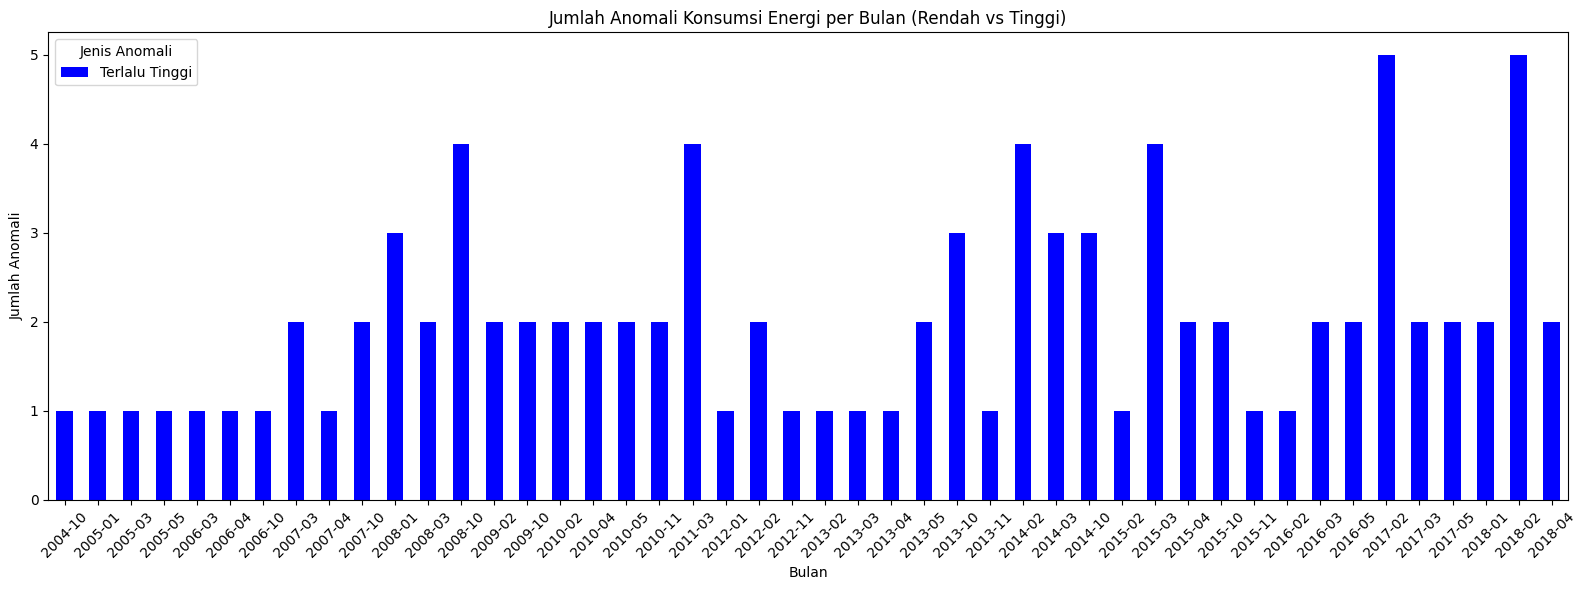

In [119]:
import matplotlib.pyplot as plt

# Pastikan kolom tanggal dalam datetime
anomalies['Bulan'] = anomalies.index.to_period('M')

# Hitung jumlah anomali per bulan berdasarkan jenis
monthly_anomalies = anomalies.groupby(['Bulan', 'tipe_anomali']).size().unstack(fill_value=0)

# Visualisasi
plt.figure(figsize=(16, 6))
monthly_anomalies.plot(kind='bar', stacked=True, color=['blue', 'red'], figsize=(16,6))
plt.title('Jumlah Anomali Konsumsi Energi per Bulan (Rendah vs Tinggi)')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Anomali')
plt.xticks(rotation=45)
plt.legend(title='Jenis Anomali')
plt.tight_layout()
plt.show()


C:\Users\71477\AppData\Local\Temp\ipykernel_33720\4214830427.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=anomali_per_bulan.index,


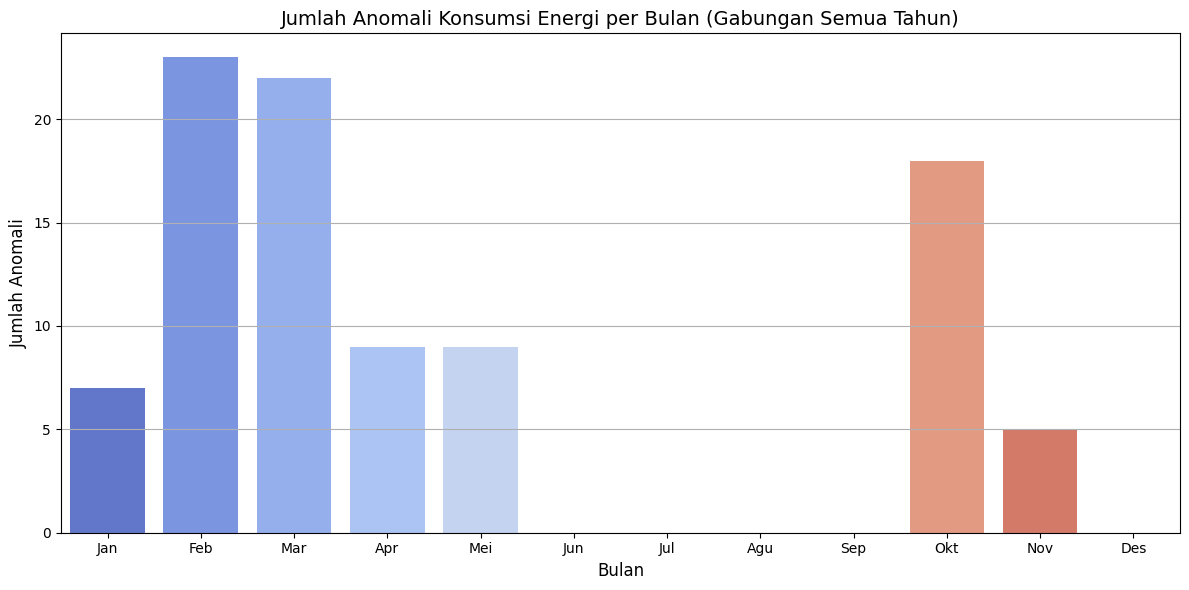

In [131]:
anomalies['Bulan'] = anomalies.index.month
anomali_per_bulan = anomalies.groupby('Bulan').size().reindex(range(1, 13), fill_value=0)

# Visualisasi bar dengan urutan bulan rapi
plt.figure(figsize=(12,6))
sns.barplot(x=anomali_per_bulan.index,
            y=anomali_per_bulan.values,
            palette='coolwarm')

plt.title('Jumlah Anomali Konsumsi Energi per Bulan (Gabungan Semua Tahun)', fontsize=14)
plt.xlabel('Bulan', fontsize=12)
plt.ylabel('Jumlah Anomali', fontsize=12)
plt.xticks(ticks=range(0,12), 
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'Mei', 'Jun',
                   'Jul', 'Agu', 'Sep', 'Okt', 'Nov', 'Des'])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

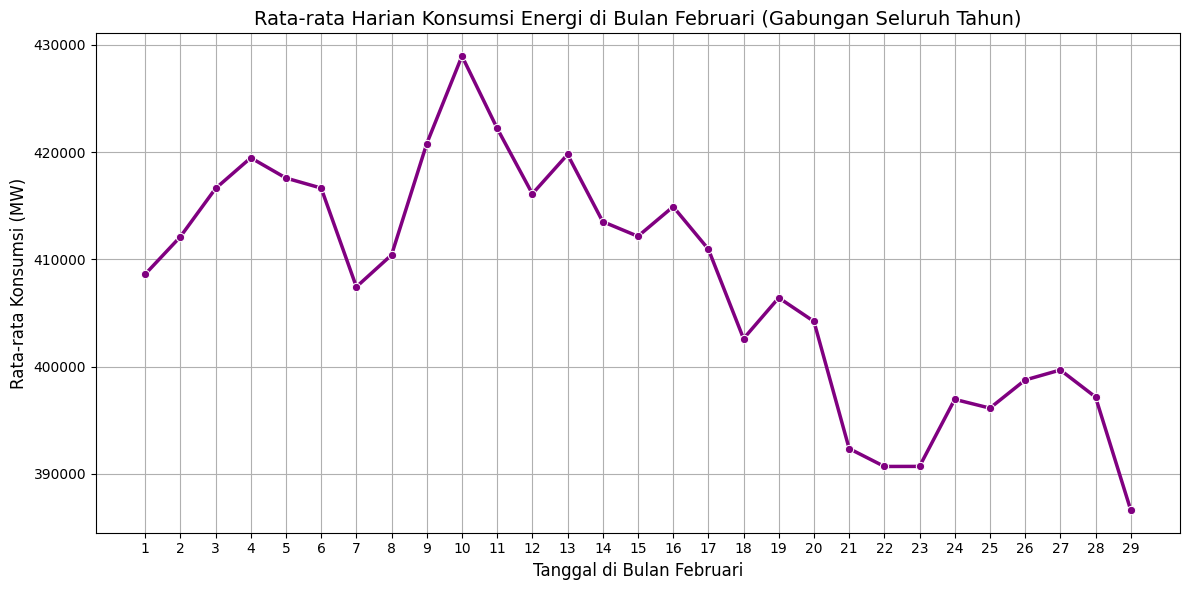

In [ ]:
# Pastikan index datetime
AEPdaily.index = pd.to_datetime(AEPdaily.index)

# Ambil hanya bulan Februari dari semua tahun
february = AEPdaily[AEPdaily.index.month == 2].copy()

# Tambahkan kolom hari dalam bulan
february['Day'] = february.index.day

# Hitung rata-rata untuk setiap tanggal (1–29, jika ada kabisat)
feb_avg = february.groupby('Day')['AEP_MW'].mean()

# Visualisasi
plt.figure(figsize=(12,6))
sns.lineplot(x=feb_avg.index, y=feb_avg.values, marker='o', linewidth=2.5, color='purple')
plt.title('Rata-rata Harian Konsumsi Energi di Bulan Februari (Gabungan Seluruh Tahun)', fontsize=14)
plt.xlabel('Tanggal di Bulan Februari', fontsize=12)
plt.ylabel('Rata-rata Konsumsi (MW)', fontsize=12)
plt.xticks(ticks=range(1,30))
plt.grid(True)
plt.tight_layout()
plt.show()


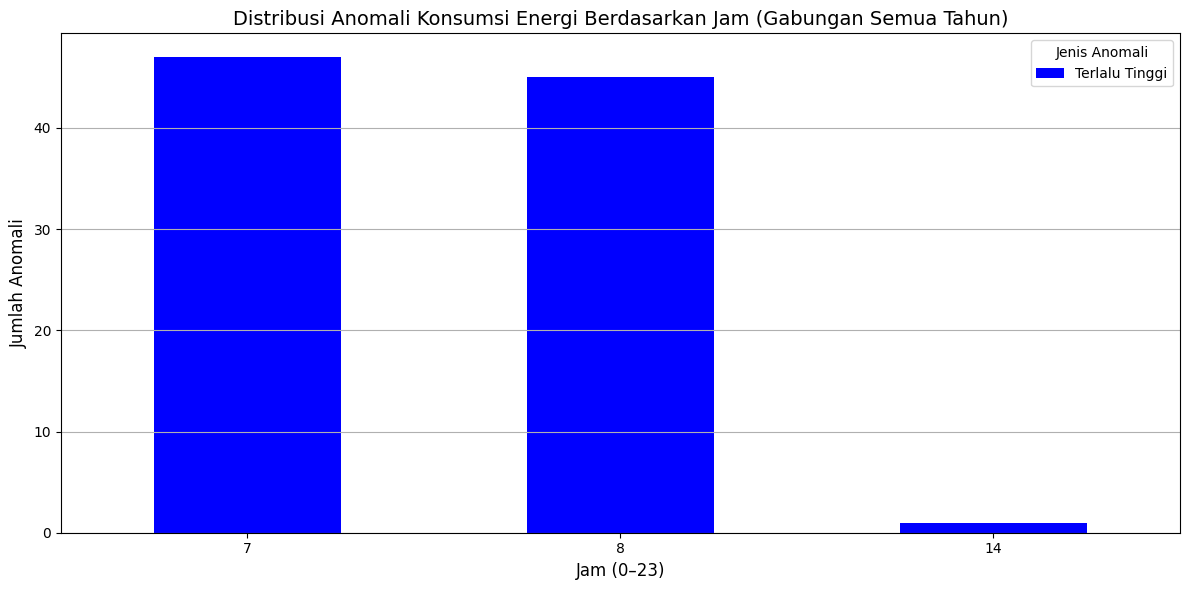

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pastikan index datetime
anomalies.index = pd.to_datetime(anomalies.index)

# Ekstrak jam dari index datetime
anomalies['Jam'] = anomalies.index.hour

# Hitung jumlah anomali per jam berdasarkan jenis anomali
anomaly_by_hour = anomalies.groupby(['Jam', 'tipe_anomali']).size().unstack(fill_value=0)

# Visualisasi
plt.figure(figsize=(12,6))
anomaly_by_hour.plot(kind='bar', stacked=True, color=['blue', 'red'], ax=plt.gca())
plt.title('Distribusi Anomali Konsumsi Energi Berdasarkan Jam (Gabungan Semua Tahun)', fontsize=14)
plt.xlabel('Jam (0–23)', fontsize=12)
plt.ylabel('Jumlah Anomali', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Jenis Anomali')
plt.grid(axis='y')
plt.tight_layout()
plt.show()
